# Compare CPU time and memory usage

This notebook runs some benchmarks to compare the execution time and the peak memory usage with various codes:

- ccdproc: https://github.com/astropy/ccdproc
- DRAGONS: https://github.com/GeminiDRSoftware/DRAGONS
- imcombinepy: https://github.com/ysBach/imcombinepy

Some points to note to interpret the results:

- ccdproc:
  - By default only one iteration for sigma clipping. Possibility to use Astropy's optimized sigma clipping, but not exposed via the `combine` function.
  - Does not propagate the variance, compute a statistical uncertainty from the data (i.e. stddev of the data values).
- DRAGONS: 
  - Always cast data to float32
  - If variance is not given as input, it calculates one from the data (see [NDStacker.calculate_variance](https://github.com/GeminiDRSoftware/DRAGONS/blob/4c0bcaead8a0368de3e6204f2728325404298d9e/gempy/library/nddops.py#L260)).
- imcombinepy:
  - Does not propagate the variance, if `full=True` compute a statistical uncertainty from the data (i.e. stddev of the data values).

In [1]:
#%load_ext memory_profiler
#%load_ext line_profiler

%matplotlib inline

import datetime

import numpy as np
from astropy.table import Table, join, vstack
from matplotlib import pyplot as plt

from combine import Compare, barplot

In [2]:
PARAMS = dict(limit=None,
              datadir='~/data/combiner',
              dtype='float32',
              with_uncertainty=False)

## Compare results

In [3]:
comp = Compare(**PARAMS)

In [4]:
#plt.imshow(comp.ccds[0].data, vmin=200, vmax=250, origin='lower')
#plt.colorbar();

In [5]:
comp.setup_ndcombine()
res_ndcombine = comp.ndcombine(method='mean',
                               clipping_method='sigclip',
                               clipping_limits=(3, 3))

In [6]:
comp.setup_ccdproc()
res_ccdproc = comp.ccdproc(sigma_clip=True,
                           sigma_clip_low_thresh=3,
                           sigma_clip_high_thresh=3)

In [7]:
comp.setup_dragons()
res_dragons = comp.dragons(mclip=True, lsigma=3, hsigma=3, max_iters=100)

In [8]:
comp.setup_imcombinepy()
res_imcombinepy = comp.imcombinepy(combine='mean',
                                   reject='sigclip',
                                   cenfunc='median',
                                   sigma=[3., 3.],
                                   maxiters=100)

In [9]:
def compare(a, b, precision=1e-4):
    print(np.count_nonzero(np.abs(a - b) < precision) / np.prod(a.shape))

In [10]:
compare(res_ccdproc.data, res_ndcombine.data)

0.9812545776367188


In [11]:
compare(res_dragons.data, res_ndcombine.data)

0.9667685031890869


In [12]:
compare(res_imcombinepy, res_ndcombine.data)

0.9893600940704346


## Compare memory

In [13]:
comp = Compare(**PARAMS)
res_mem = comp.measure_memory()

Running ndcombine - mean : 316.8 Mb
Running ndcombine - mean+sigclip : 317.7 Mb
Running ndcombine - median : 311.5 Mb
Running ccdproc - mean : 557.0 Mb
Running ccdproc - mean+sigclip : 1863.9 Mb
Running ccdproc - median : 1999.1 Mb
Running dragons - mean : 1919.3 Mb
Running dragons - mean+sigclip : 1487.0 Mb
Running dragons - median : 2558.5 Mb
Running imcombinepy - mean : 631.4 Mb
Running imcombinepy - mean+sigclip : 1655.7 Mb
Running imcombinepy - median : 634.7 Mb


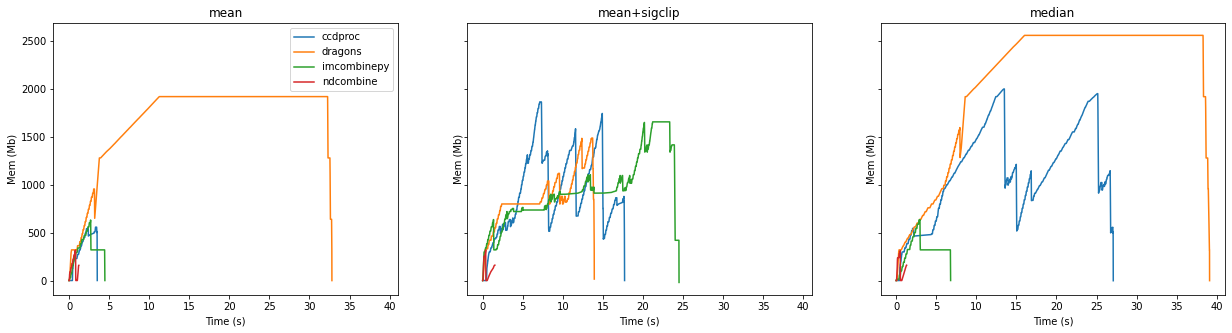

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5), sharex=True, sharey=True)
for ax, bench in zip(axes, sorted(set(res_mem['benchmark']))):
    for code in sorted(set(res_mem['package'])):
        data = res_mem[(res_mem['package'] == code)
                       & (res_mem['benchmark'] == bench)]
        data = data['memory_usage'][0]
        data -= data[0]
        mem, timestamp = data.T
        ax.plot(timestamp, mem, label=code)
    ax.set(title=bench, xlabel='Time (s)', ylabel='Mem (Mb)')
axes[0].legend();

## Compare runtime

In [15]:
comp = Compare(**PARAMS)
res_cpu = comp.measure_times()

Running ndcombine - mean...... Mean of 5 : 1.05±0.01 sec.
Running ndcombine - mean+sigclip...... Mean of 5 : 4.55±0.07 sec.
Running ndcombine - median...... Mean of 5 : 3.74±0.01 sec.
Running ccdproc - mean...... Mean of 5 : 4.34±0.16 sec.
Running ccdproc - mean+sigclip...... Mean of 5 : 21.60±1.19 sec.
Running ccdproc - median...... Mean of 5 : 35.63±1.02 sec.
Running dragons - mean...... Mean of 5 : 33.85±0.61 sec.
Running dragons - mean+sigclip...... Mean of 5 : 14.48±1.08 sec.
Running dragons - median...... Mean of 5 : 41.21±2.20 sec.
Running imcombinepy - mean...... Mean of 5 : 4.02±0.25 sec.
Running imcombinepy - mean+sigclip...... Mean of 5 : 27.26±2.93 sec.
Running imcombinepy - median...... Mean of 5 : 7.84±1.53 sec.


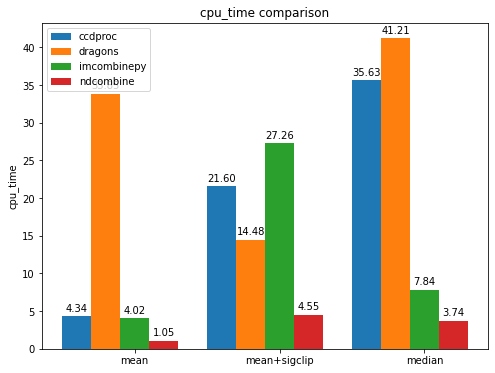

In [16]:
barplot(res_cpu, col='cpu_time')

## Combined results

In [17]:
t = join(res_mem, res_cpu, keys=('package', 'benchmark'))

In [18]:
t

package,benchmark,memory_peak,cpu_time
str11,str12,float64,float64
ccdproc,mean,959,4.34
ccdproc,mean+sigclip,2133,21.60
ccdproc,median,3005,35.63
dragons,mean,1919,33.85
dragons,mean+sigclip,1492,14.48
dragons,median,2560,41.21
imcombinepy,mean,635,4.02
imcombinepy,mean+sigclip,1652,27.26
imcombinepy,median,634,7.84


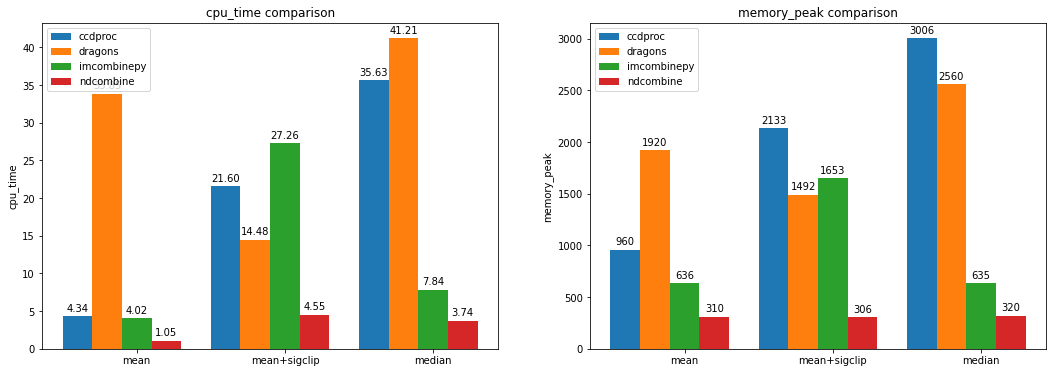

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
barplot(t, col='cpu_time', ax=ax1)
barplot(t, col='memory_peak', ax=ax2, label_fmt='.0f')

In [28]:
#t.write(f'timings-20img-2048x2048-{datetime.datetime.now().isoformat()}.ecsv')

## Compare dtype and uncertainty

In [4]:
tbl = Table()

for dtype in ('float32', 'float64'):
    for unc in (False, True):
        print(f'==== {dtype}-{unc} ====')
        params = PARAMS.copy()
        params.update({'dtype': dtype, 'with_uncertainty': unc})
        comp = Compare(**params)
        res_mem = comp.measure_memory()
        res_cpu = comp.measure_times()
        t2 = join(res_mem, res_cpu, keys=('package', 'benchmark'))
        t2['dtype'] = dtype
        t2['with_uncertainty'] = unc
        tbl = vstack([tbl, t2])

==== float32-False ====
Running ndcombine - mean : 350.9 Mb
Running ndcombine - mean+sigclip : 351.7 Mb
Running ndcombine - median : 351.4 Mb
Running ccdproc - mean : 1272.2 Mb
Running ccdproc - mean+sigclip : 2548.2 Mb
Running ccdproc - median : 3315.9 Mb
Running dragons - mean : 2016.1 Mb
Running dragons - mean+sigclip : 1784.0 Mb
Running dragons - median : 2671.9 Mb
Running imcombinepy - mean : 635.9 Mb
Running imcombinepy - mean+sigclip : 1987.3 Mb
Running imcombinepy - median : 638.0 Mb
Running ndcombine - mean...... Mean of 5 : 1.07±0.01 sec.
Running ndcombine - mean+sigclip...... Mean of 5 : 4.59±0.02 sec.
Running ndcombine - median...... Mean of 5 : 3.83±0.03 sec.
Running ccdproc - mean...... Mean of 5 : 5.79±0.13 sec.
Running ccdproc - mean+sigclip...... Mean of 5 : 33.38±3.96 sec.
Running ccdproc - median...... Mean of 5 : 58.22±4.91 sec.
Running dragons - mean...... Mean of 5 : 30.88±0.28 sec.
Running dragons - mean+sigclip...... Mean of 5 : 23.27±2.93 sec.
Running dragons -

In [14]:
#del tbl['memory_usage']
tbl.write(f'timings-20img-2048x2048-{datetime.datetime.now().isoformat()}.ecsv')

In [4]:
tbl = Table.read('timings-20img-2048x2048-2022-01-11T14:00:13.711388.ecsv')

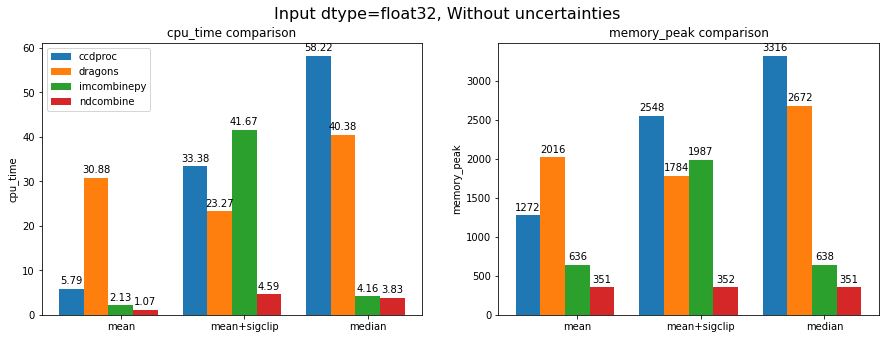

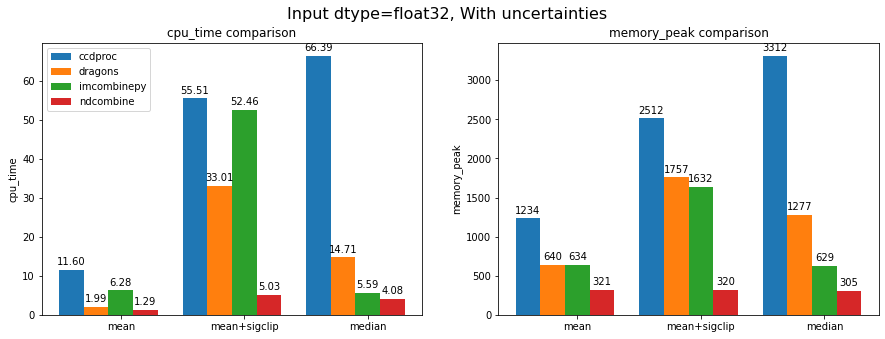

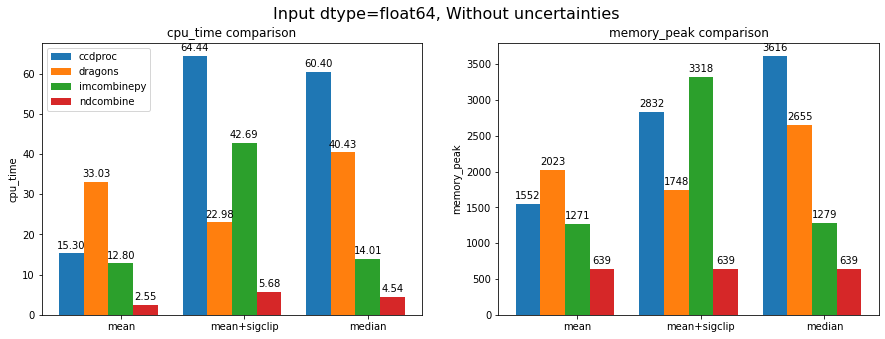

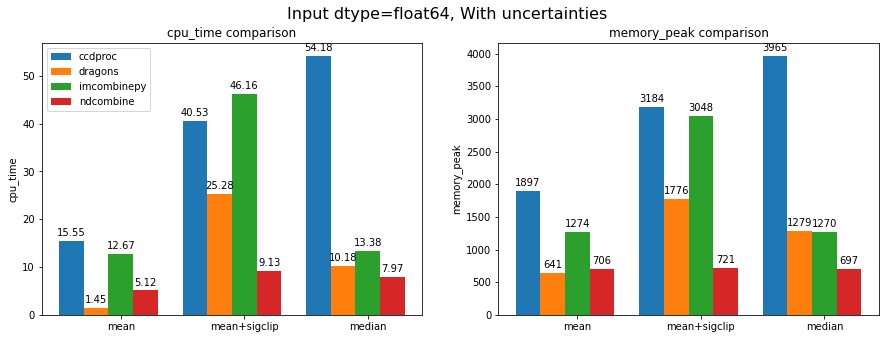

In [7]:
for dtype in ('float32', 'float64'):
    for unc in (False, True):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        t = tbl[(tbl['dtype'] == dtype) & (tbl['with_uncertainty'] == unc)]
        barplot(t, col='cpu_time', ax=ax1)
        barplot(t, col='memory_peak', ax=ax2, label_fmt='.0f', legend=False)
        unc_label = 'With' if unc else 'Without'
        fig.suptitle(f'Input dtype={dtype}, {unc_label} uncertainties', fontsize=16)